<a href="https://colab.research.google.com/github/eshasadia/PanNuke/blob/main/lightning_hovernet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0 Download & format dataset

To be run once

### 0.1 Download original dataset

In [1]:
%%shell
count=$(find /content/data/monuseg -maxdepth 5 -type f|wc -l)
if [ $count -gt 80 ]
then
    echo "Looks like files have already been downloaded."
else
    echo "Downloading files..."
    # Create directory structure
    rm -r data/monuseg                                                            # Use -f to remove without complaining
    mkdir data data/monuseg data/monuseg/train data/monuseg/test data/monuseg/val # Use -p to create without complaining

    # Download training data
    export fileid=1JZN9Jq9km0rZNiYNEukE_8f0CsSK3Pe4
    export filename=MoNuSegTrainingData.zip
    wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    wget --load-cookies cookies.txt -O $filename 'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    # Remove annoyances
    zip -d MoNuSegTrainingData.zip '__MACOSX*'
    zip -d MoNuSegTrainingData.zip '*.DS_Store'
    # Extract 
    unzip MoNuSegTrainingData.zip
    # Cleanup
    rm confirm.txt cookies.txt MoNuSegTrainingData.zip

    # Download testing data
    export fileid=1NKkSQ5T0ZNQ8aUhh0a8Dt2YKYCQXIViw
    export filename=MoNuSegTestingData.zip
    wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    wget --load-cookies cookies.txt -O $filename 'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    # Extract
    unzip MoNuSegTestingData.zip
    # Cleanup
    rm confirm.txt cookies.txt MoNuSegTestingData.zip

    # Organise
    mv MoNuSeg\ Training\ Data/* data/monuseg/train
    mv MoNuSegTestData/* data/monuseg/test
    mkdir data/monuseg/test/Annotations data/monuseg/test/Tissue\ Images
    mv data/monuseg/test/*.xml data/monuseg/test/Annotations
    mv data/monuseg/test/*.tif data/monuseg/test/Tissue\ Images
    rm -rf MoNuSeg\ Training\ Data MoNuSegTestData
fi

find: ‘/content/data/monuseg’: No such file or directory
rm: cannot remove 'data/monuseg': No such file or directory
--2022-10-22 10:24:14--  https://docs.google.com/uc?export=download&id=1JZN9Jq9km0rZNiYNEukE_8f0CsSK3Pe4
Resolving docs.google.com (docs.google.com)... 172.217.194.102, 172.217.194.100, 172.217.194.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

-                       [ <=>                ]   2.22K  --.-KB/s    in 0s      

2022-10-22 10:24:15 (42.2 MB/s) - written to stdout [2272]

--2022-10-22 10:24:15--  https://docs.google.com/uc?export=download&id=1JZN9Jq9km0rZNiYNEukE_8f0CsSK3Pe4&confirm=t
Resolving docs.google.com (docs.google.com)... 172.217.194.102, 172.217.194.100, 172.217.194.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.102|:443... connected.
HTTP request sent, awaiting response... 303 See Othe

### 0.2 Create 270 x 270 patches

In [3]:
import os
import numpy as np
from PIL import Image
from xml.dom import minidom
from skimage.draw import polygon
import scipy.io as sio

seed = np.random.RandomState(42)
width = 24
height = 24
angle = 180
sig = 4
alpha = 20
patch_size = np.array([270,270])
stride = 53

def generate_labelled_array(shape, xml_file):
    """
    Given the image shape and path to annotations(xml file), 
    generate a bit mask with the region inside a contour being white
    shape: The image shape on which bit mask will be made
    xml_file: path relative to the current working directory 
    where the xml file is present
    Returns: A image of given shape with region inside contour being white..
    """
    # DOM object created by the minidom parser
    xDoc = minidom.parse(xml_file)

    # List of all Region tags
    regions = xDoc.getElementsByTagName('Region')

    # List which will store the vertices for each region
    xy = []
    for region in regions:
        # Loading all the vertices in the region
        vertices = region.getElementsByTagName('Vertex')

        # The vertices of a region will be stored in a array
        vw = np.zeros((len(vertices), 2))

        for index, vertex in enumerate(vertices):
            # Storing the values of x and y coordinate after conversion
            vw[index][0] = float(vertex.getAttribute('X'))
            vw[index][1] = float(vertex.getAttribute('Y'))
        
        # Append the vertices of a region
        xy.append(np.int32(vw))

    # Creating a completely black image
    mask = np.zeros(shape, np.float32)

    for i, contour in enumerate(xy):
        r, c = polygon(np.array(xy[i])[:,1],np.array(xy[i])[:,0],shape=shape)
        mask[r,c] = i
    return mask
    
# TODO: Provide better names
def create_patch(path_anot, path_img, save_path_anot, save_path_img, patch_size, img_name, stride):
    """
    Goes through the files in path_anot as well as path_img, loads the image
    from path_img and generates the bit_mask from path_anot. Goes around the 
    image in both to extract patches of size specified above.
    Saves them into the location given by save_path.
    The path is a LIST of corresponding path names.
    """
    for j, (p_a, p_i, img_n) in enumerate(zip(path_anot, path_img, img_name)):
        print(f"{j + 1 : >3}: {img_n}")
        img = np.array(Image.open(p_i))
        i_h, i_w = img.shape[:2]
        p_h, p_w = patch_size

        bit_m = generate_labelled_array((1000,1000),p_a)
        assert img.shape[:2] == bit_m.shape
        
        for i, x in enumerate(range(0, i_w - p_w + 1, stride)):
            for y in range(0, i_h - p_h + 1, stride):
                patch_img = img[x:x+p_w, y:y+p_h]
                patch_bit = bit_m[x:x+p_w, y:y+p_h]

                img_path_save = save_path_img + "/" +img_n + "_" + str(i + 1) + ".png"
                Image.fromarray(patch_img).save(img_path_save)
                mat_path_save = save_path_anot +"/" + img_n + "_" + str(i + 1) + ".mat"
                sio.savemat(mat_path_save, {'data':patch_bit})


def make_directory_structure(dir_xml, dir_img, save_path_anot, save_path_img, img_extension):
    if os.path.exists(save_path_anot):
        print("Looks like patches have been created.")
        return 
        # shutil.rmtree(save_path_anot)
    os.makedirs(save_path_anot)

    if os.path.exists(save_path_img):
        print("Looks like patches have been created")
        return
        # shutil.rmtree(save_path_img)
    os.makedirs(save_path_img)

    path_anot = []
    path_img = []
    img_name_list = []

    for img_name, xml_name in zip(os.listdir(dir_img), os.listdir(dir_xml)):
        img_name = img_name.split('.')[0]
        path_anot.append(dir_xml + "/" + img_name + ".xml")
        path_img.append(dir_img  + "/" + img_name + img_extension)
        img_name_list.append(img_name)

    create_patch(path_anot, path_img, save_path_anot, save_path_img, patch_size, img_name_list, stride)


make_directory_structure(
    dir_xml='data/monuseg/train/Annotations',
    dir_img='data/monuseg/train/Tissue Images',
    save_path_anot='data/raw/train/masks',
    save_path_img='data/raw/train/imgs',
    img_extension='.png'
)
    
make_directory_structure(
    dir_xml='data/monuseg/test/Annotations',
    dir_img='data/monuseg/test/Tissue Images',
    save_path_anot='data/raw/test/masks',
    save_path_img='data/raw/test/imgs',
    img_extension='.tif'
)

Looks like patches have been created.
  1: TCGA-A6-6782-01A-01-BS1
  2: TCGA-44-2665-01B-06-BS6
  3: TCGA-CU-A0YN-01A-02-BSB
  4: TCGA-IZ-8196-01A-01-BS1
  5: TCGA-HC-7209-01A-01-TS1
  6: TCGA-EJ-A46H-01A-03-TSC
  7: TCGA-AC-A2FO-01A-01-TS1
  8: TCGA-2Z-A9J9-01A-01-TS1
  9: TCGA-AO-A0J2-01A-01-BSA
 10: TCGA-FG-A4MU-01B-01-TS1
 11: TCGA-69-7764-01A-01-TS1
 12: TCGA-GL-6846-01A-01-BS1
 13: TCGA-ZF-A9R5-01A-01-TS1
 14: TCGA-HT-8564-01Z-00-DX1


### 0.3 Viz patches

In [ ]:
from pathlib import Path
import scipy.io as sio
from PIL import Image
import matplotlib.pyplot as plt

img_paths = sorted(list((Path('data/raw/train') / 'imgs').glob('*.png')))

# Open random (image, mask) pair
fid = np.random.randint(len(img_paths))
img = np.array(Image.open(img_paths[fid]))
msk = sio.loadmat(Path('data/raw/train') / 'masks'/ (img_paths[fid].stem + '.mat'))['data']

print(np.unique(msk))

fig, axarr = plt.subplots(1, 3, figsize=(15, 15))
axarr[0].imshow(img)
axarr[1].imshow(msk)
axarr[2].imshow(img)
axarr[2].imshow(msk, alpha=0.4)
plt.show()

In [ ]:
# Load gdrive and save generated patches to gdrive
from google.colab import drive
drive.mount('/gdrive')

import shutil
shutil.move('/content/data', '/gdrive/My Drive/Research/datasets/MoNuSeg_correct/')

## 1 Installs & Imports

In [ ]:
!pip install albumentations==0.4.5 https://github.com/PyTorchLightning/pytorch-lightning/archive/0.7.6rc1.zip > /dev/null

In [ ]:
# PyTorch
import torch
import pytorch_lightning as pl
from torch import nn as nn
from torch.nn import functional as F
from torchvision.utils import save_image, make_grid
import albumentations
from albumentations.augmentations import transforms as tf
from albumentations.core.composition import Compose
from albumentations.pytorch import ToTensorV2

# Image processing
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from scipy import ndimage
from scipy.ndimage import measurements
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import affine_transform, map_coordinates
from scipy.ndimage.morphology import (distance_transform_cdt, distance_transform_edt)
import scipy.io as sio
from skimage import morphology as morph
from PIL import Image # ⚠️ DON'T use both PIL and cv2 for image read/write 

# OS
from pathlib import Path
# Logging
import logging

# Check versions
torch.__version__, pl.__version__, albumentations.__version__

('1.5.0+cu101', '0.7.6rc1', '0.4.5')

### 1.1 Important constants & inits

In [ ]:
# Load gdrive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Deterministic runs
# https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Logger
logger = logging.getLogger('hovernet')
logger.setLevel(logging.DEBUG)

# Constants
IM_SZ       = 270       # Size of images going into the network
MK_SZ       = 80        # Size of masks going into the network
IN_CHANNELS = 3         # Number of channels in images going into the net
DS_ROOT     = '/gdrive/My Drive/Research/datasets/MoNuSeg_correct/raw/' # Location of the dataset with `train`, `val` & `test` directories

## 2 Dataset API

### 2.1 Utils

In [ ]:
# Important utils

def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # Due to python indexing, we need to add 1 to `rmax` & `cmax`
    # or else accessing will be 1px in the box, not out of it.
    rmax += 1
    cmax += 1
    return [rmin, rmax, cmin, cmax]

def cropping_center(x, crop_shape, batch=False):   
    orig_shape = x.shape
    if not batch:
        h0 = int((orig_shape[0] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[1] - crop_shape[1]) * 0.5)
        x = x[h0:h0 + crop_shape[0], w0:w0 + crop_shape[1]]
    else:
        h0 = int((orig_shape[1] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[2] - crop_shape[1]) * 0.5)
        x = x[:,h0:h0 + crop_shape[0], w0:w0 + crop_shape[1]]        
    return x


from cv2 import moments
def get_inst_centroid(inst_map):
    inst_centroid_list = []
    inst_id_list = list(np.unique(inst_map))
    for inst_id in inst_id_list[1:]: # Avoid 0 i.e. the background.
        mask = np.array(inst_map == inst_id, np.uint8)
        inst_moment = moments(mask)
        inst_centroid = [(inst_moment["m10"] / inst_moment["m00"]), (inst_moment["m01"] / inst_moment["m00"])]
        inst_centroid_list.append(inst_centroid)
    return np.array(inst_centroid_list)


def fix_mirror_padding(ann):
    """
    Deal with duplicated instances due to mirroring in interpolation
    during shape augmentation (scale, rotation etc.)
    """
    current_max_id = np.amax(ann)
    inst_list = list(np.unique(ann))
    inst_list.remove(0)              # Avoid 0 i.e. the background.
    for inst_id in inst_list:
        inst_map = np.array(ann == inst_id, np.uint8)
        remapped_ids = measurements.label(inst_map)[0]
        remapped_ids[remapped_ids > 1] += current_max_id
        ann[remapped_ids > 1] = remapped_ids[remapped_ids > 1]
        current_max_id = np.amax(ann)
    return ann
    

### 2.2 Dataset API

In [ ]:
# Dataset API

class OrganDataset(torch.utils.data.Dataset):
    def __init__(self, phase):
        assert(phase in ["train", "val", "test"])
        self.phase       = phase
        self.root        = DS_ROOT
        self.image_dir   = "imgs"
        self.mask_dir    = "masks"
        self.image_glob  = "*.tif" if phase == "val" else "*.png"
        self.image_paths = self.get_image_paths()
        self.transforms  = self.get_transforms()

        assert(len(self.image_paths) > 0)

    def __getitem__(self, idx):
        # Read image with PIL
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path)
        except IOError:
            logger.error(f"Unable to load image: {image_path}")
        # Convert `Image` to `np.ndarray`
        image = np.array(image)

        # Return only images for test phase
        if self.phase == "test":
            augmented   = self.transforms['common'](image=image)
            new_image   = self.transforms['img_only'](image=augmented['image'])
            aug_tensors = self.transforms['final'](image=new_image['image'])
            image       = aug_tensors['image']
            return image

        # Read mask using `scipy.io.loadmat`
        # <<< Note: Mask is supposed to have the same filename as image
        mask_path = Path(self.root) / self.phase / self.mask_dir / (image_path.stem + '.mat')
        try:
            mask = sio.loadmat(mask_path)['data'].astype(np.int32)
        except IOError:
            logger.error(f"Unable to load mask: {mask_path}")

        # 🚧 Refactor this terrible looking pipeline
        # Data augmentation & convert to Tensor
        augmented         = self.transforms['common'](image=image, mask=mask)
        rsoa_mask, hv_map = OrganDataset.gen_instance_hv(augmented['mask'])
        
        norm_image        = self.transforms['img_only'](image=augmented['image'])['image']
        crop_rsoa_mask    = self.transforms['mask_only'](image=rsoa_mask)['image']            
        crop_hv_map       = self.transforms['mask_only'](image=hv_map)['image']              

        final_tensors     = self.transforms['final'](image=norm_image, mask=crop_rsoa_mask)
        final_hv_map      = self.transforms['final'](image=crop_hv_map)['image']
        final_image       = final_tensors['image']
        final_mask_np     = final_tensors['mask']
        # The NP branch outputs semantic segmentation of nuclei i.e. masks are binary {0, 1}
        final_mask_np = torch.where(final_mask_np != 0, torch.tensor(1.0), torch.tensor(0.0))
        # One hot coding for targets of the NP branch
        final_mask_np = F.one_hot(final_mask_np.long(), num_classes=2)
        # Convert HWC to CHW
        final_mask_np = final_mask_np.permute(2, 0, 1)

        return final_image, final_mask_np, final_hv_map

    def __len__(self):
        return len(self.image_paths)

    def get_image_paths(self):
        """Get sorted list of image paths"""
        _path_to_imgs = Path(self.root) / self.phase / self.image_dir
        return sorted(list(_path_to_imgs.glob(self.image_glob)))

    def get_transforms(self):
        """Get all transforms for current phase"""
        common_tfs = []
        if self.phase == "train":
            common_tfs.extend([
                tf.ShiftScaleRotate(shift_limit=0, scale_limit=0.1, rotate_limit=15, p=0.5),
                tf.Flip(p=0.5),
                tf.RandomRotate90(p=0.5),
            ])
        common_tfs.extend([
            tf.RandomSizedCrop(min_max_height=(IM_SZ, IM_SZ), height=IM_SZ, width=IM_SZ, w2h_ratio=1.0, always_apply=True),
        ])

        left = top = (IM_SZ - MK_SZ) // 2
        right = bottom = (IM_SZ + MK_SZ) // 2
        mask_only_tfs = [
            tf.Crop(left, top, right, bottom, always_apply=True),
        ]
        img_only_tfs = [ tf.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), always_apply=True) ]
        final_tfs = [ ToTensorV2() ]

        tfs = {
            'common':    Compose(common_tfs),
            'img_only':  Compose(img_only_tfs),
            'mask_only': Compose(mask_only_tfs),
            'final':     Compose(final_tfs)
        }
        return tfs 

    @staticmethod
    def gen_instance_hv(id_map):
        """Generate distance maps - https://github.com/vqdang/hover_net/blob/master/src/loader/augs.py#L192"""
        # 🚧 Give more descriptive names, follow logic path & annotate lines

        # Copy in the provided mask
        orig_ann = np.copy(id_map)
        crop_ann = orig_ann

        # Remove objects smaller than specified `min_size`
        removed_small_obj_ann = morph.remove_small_objects(orig_ann, min_size=100)
    
        # Create and initialize horizontal & vertical maps
        x_map = np.zeros(orig_ann.shape[:2], dtype=np.float32)
        y_map = np.zeros(orig_ann.shape[:2], dtype=np.float32)
    
        # Get all the labels in the `removed_small_obj_ann` mask
        inst_list = list(np.unique(removed_small_obj_ann))
        # Remove `0` - The background
        inst_list.remove(0) 
        
        # For each label
        for inst_id in inst_list:
            # Get all pixels corresponding to that label
            inst_map = np.array(removed_small_obj_ann == inst_id, np.uint8)
            inst_box = bounding_box(inst_map)
            inst_map = inst_map[inst_box[0]:inst_box[1], inst_box[2]:inst_box[3]]
    
            if inst_map.shape[0] < 2 or inst_map.shape[1] < 2:
                continue
    
            # Instance's center of mass, rounded to nearest pixel
            inst_com = list(measurements.center_of_mass(inst_map))
            # 🚧 Remove float NAN error or handle it
            inst_com[0] = int(inst_com[0] + 0.5)
            inst_com[1] = int(inst_com[1] + 0.5)
    
            inst_x_range = np.arange(1, inst_map.shape[1]+1)
            inst_y_range = np.arange(1, inst_map.shape[0]+1)
            # Shift center of pixel grid to instance's center of mass
            inst_x_range -= inst_com[1]
            inst_y_range -= inst_com[0]
            
            inst_x, inst_y = np.meshgrid(inst_x_range, inst_y_range)
    
            # Remove co-ordinates outside instance
            inst_x[inst_map == 0] = 0
            inst_y[inst_map == 0] = 0
            inst_x = inst_x.astype('float32')
            inst_y = inst_y.astype('float32')
    
            # Normalize min into -1 scale
            if np.min(inst_x) < 0:
                inst_x[inst_x < 0] /= (-np.amin(inst_x[inst_x < 0]))
            if np.min(inst_y) < 0:
                inst_y[inst_y < 0] /= (-np.amin(inst_y[inst_y < 0]))

            # Normalize max into +1 scale
            if np.max(inst_x) > 0:
                inst_x[inst_x > 0] /= (np.amax(inst_x[inst_x > 0]))
            if np.max(inst_y) > 0:
                inst_y[inst_y > 0] /= (np.amax(inst_y[inst_y > 0]))
    
            x_map_box = x_map[inst_box[0]:inst_box[1], inst_box[2]:inst_box[3]]
            x_map_box[inst_map > 0] = inst_x[inst_map > 0]
    
            y_map_box = y_map[inst_box[0]:inst_box[1], inst_box[2]:inst_box[3]]
            y_map_box[inst_map > 0] = inst_y[inst_map > 0]
    
        hv_map = np.dstack([x_map, y_map])

        return removed_small_obj_ann, hv_map


### 2.3 Viz dataset

Shapes - Inputs: torch.Size([4, 3, 270, 270]) NP Masks: torch.Size([4, 2, 80, 80]), HV Maps: torch.Size([4, 2, 80, 80])


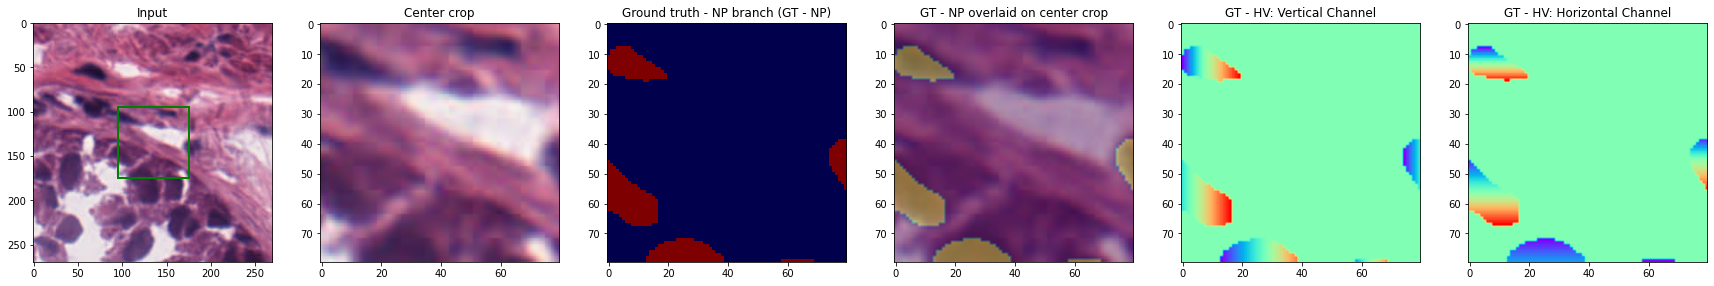

In [ ]:
# Test the dataset & dataloader

ds = OrganDataset("train")
train_loader = torch.utils.data.DataLoader(ds, batch_size=4, num_workers=2, pin_memory=False, shuffle=True)
data = next(iter(train_loader))

# Print shapes of dataloader output
print(f"Shapes - Inputs: {data[0].shape} NP Masks: {data[1].shape}, HV Maps: {data[2].shape}")

fig, axarr = plt.subplots(1, 6, figsize=(30, 30))

# Original Input
img = data[0][0].detach().cpu().permute(1, 2, 0).numpy()
img = Image.fromarray((img * 255).astype(np.uint8))
axarr[0].imshow(img)
axarr[0].add_patch(patches.Rectangle((95, 95), 80, 80, linewidth=2, edgecolor='g', facecolor='none'))
axarr[0].title.set_text('Input')

# Cropped input
crop_img = img.crop((95, 95, 175, 175))
axarr[1].imshow(np.array(crop_img))
axarr[1].title.set_text('Center crop')

# Target for NP branch 
# <<< NOTE: NP mask is one_hot encoded and has shape [N 2 80 80]
# <<< NOTE: np_mask[:, 1, :, :] is the old np_mask
np_mask = (data[1][0].detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
axarr[2].imshow(np_mask[:, :, 1], 'seismic')
axarr[2].title.set_text('Ground truth - NP branch (GT - NP)')

# Target for NP branch overlaid on cropped input 
axarr[3].imshow(np.array(crop_img))
axarr[3].imshow(np_mask[:, :, 1], alpha=0.4)
axarr[3].title.set_text('GT - NP overlaid on center crop')

# Horizontal & vertical maps 
hv_maps = data[2][0].detach().cpu().permute(1, 2, 0).numpy()
axarr[4].imshow(hv_maps[:, :, 0], 'rainbow')
axarr[4].title.set_text('GT - HV: Vertical Channel')   # For order see: https://github.com/vqdang/hover_net/blob/576ab195e4d8d49aecce51d894d2f292deb4483d/src/model/graph.py#L256
axarr[5].imshow(hv_maps[:, :, 1], 'rainbow')
axarr[5].title.set_text('GT - HV: Horizontal Channel')

plt.show()


## 4 Architecture

### 4.1 Encoder

In [ ]:

class _BNRelu(nn.Module):
    def __init__(self, num_features):
        super(_BNRelu, self).__init__()
        self.bn   = nn.BatchNorm2d(num_features=num_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs):
        return self.relu(self.bn(inputs))


class _ResidualBlock(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride, block_number):
        super(_ResidualBlock, self).__init__()

        self.preact = _BNRelu(in_planes) if block_number==1 else nn.Identity() 

        self.conv1  = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.act1   = _BNRelu(planes)

        self.conv2  = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False) 
        self.act2   = _BNRelu(planes)

        self.conv3  = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.act3   = nn.Identity()

        if (stride != 1 or in_planes != self.expansion*planes) and block_number == 1:
            self.shortcut = nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = self.preact(x)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.act1(self.conv1(out))
        out = self.act2(self.conv2(out))
        out = self.act3(self.conv3(out))
        out = out + shortcut

        return out


class _Encoder(nn.Module):
    def __init__(self, n_blocks):
        super(_Encoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=0, bias=False) 
        self.act1 = _BNRelu(64)

        self.in_planes = 64
        self.res_unit1 = self._make_res_unit(  64, n_blocks[0], 1)
        self.res_unit2 = self._make_res_unit( 128, n_blocks[1], 2)
        self.res_unit3 = self._make_res_unit( 256, n_blocks[2], 2)
        self.res_unit4 = self._make_res_unit( 512, n_blocks[3], 2)

        self.conv2 = nn.Conv2d(2048, 1024, kernel_size=1, stride=1, bias=False) 

    def _make_res_unit(self, planes, n_blocks, stride):
        strides = [stride] + [1]*(n_blocks-1)
        res_blks = []
        
        for index, stride in enumerate(strides):
            res_blks.append(_ResidualBlock(self.in_planes, planes, stride, index + 1))
            self.in_planes = planes * _ResidualBlock.expansion            
            
        res_unit = nn.Sequential(
            *res_blks,
            _BNRelu(planes * _ResidualBlock.expansion)
        )

        return res_unit

    def forward(self, x):
        d1 = self.act1(self.conv1(x))
        d1 = self.res_unit1(d1)

        d2 = self.res_unit2(d1)

        d3 = self.res_unit3(d2)

        d4 = self.res_unit4(d3)

        d4 = self.conv2(d4)

        return [d1, d2, d3, d4]


### 4.2 Decoder

In [ ]:

def crop_op(x, cropping):
    """ Center crop image
    Args:
        x: The image to be cropped
        cropping: Final shape of the image
    """
    crop_t = cropping[0] // 2
    crop_b = cropping[0] - crop_t
    crop_l = cropping[1] // 2
    crop_r = cropping[1] - crop_l

    x = x[:, :, crop_t:-crop_b, crop_l:-crop_r]
    return x  

class _DenseBlock(nn.Module):
    def __init__(self, in_planes):
        super(_DenseBlock, self).__init__()

        self.preact = _BNRelu(in_planes)

        self.conv1  = nn.Conv2d(in_planes, 128, kernel_size=1, padding=0, bias=False)
        self.act1   = _BNRelu(128)

        self.conv2  = nn.Conv2d(128, 32, kernel_size=5, padding=0, groups=4, bias=False)

    def forward(self, x):
        out = self.preact(x)

        out = self.act1(self.conv1(out))
        
        out = self.conv2(out)

        # Crop input tensor if outputs till here don't have same shape
        x_size   = list(x.size())
        out_size = list(out.size())
        if (x_size[2] != out_size[2]) or (x_size[3] != out_size[3]):
            x_crop = crop_op(x, (x_size[2] - out_size[2], x_size[3] - out_size[3]))
        else:
            x_crop = x

        out = torch.cat((x_crop, out), 1)

        return out


class _Decoder(nn.Module):
    def __init__(self):
        super(_Decoder, self).__init__()

        self.conv3_1  = nn.Conv2d(1024, 256, kernel_size=5, stride=1, bias=False, padding=0)
        self.dense1   = self._make_dense_unit(256, 8)
        self.conv3_2  = nn.Conv2d(256+32*8, 512, kernel_size=1, stride=1, bias=False)       

        self.conv2_1  = nn.Conv2d(512, 128, kernel_size=5, stride=1, bias=False, padding=0)
        self.dense2   = self._make_dense_unit(128, 4)
        self.conv2_2  = nn.Conv2d(128+32*4, 256, kernel_size=1, stride=1, bias=False)       

        self.conv1_1  = nn.Conv2d(256, 64, kernel_size=5, stride=1, bias=False, padding=2)

    def _make_dense_unit(self, planes, num_blocks):
        dense_unit = []
        in_planes = planes

        for _ in range(num_blocks):
            dense_unit.append(_DenseBlock(in_planes))
            in_planes = in_planes + 32
        dense_unit.append(_BNRelu(in_planes))

        return nn.Sequential(*dense_unit)

    def forward(self, i):
        u3     = F.interpolate(i[-1], scale_factor=2)
        u3_sum = u3 + i[-2]
        u3     = self.conv3_1(u3_sum)
        u3     = self.dense1(u3)
        u3     = self.conv3_2(u3)

        u2     = F.interpolate(u3, scale_factor=2)
        u2_sum = u2 + i[-3]
        u2x    = self.conv2_1(u2_sum)
        u2     = self.dense2(u2x)
        u2     = self.conv2_2(u2)   

        u1     = F.interpolate(u2, scale_factor=2)
        u1_sum = u1 + i[-4]
        u1     = self.conv1_1(u1_sum)

        return [u3, u2x, u1]


### 4.3 Segmentation Head

In [ ]:

class _SegmentationHead(nn.Module):
    def __init__(self, head_type):
        super(_SegmentationHead, self).__init__()
        assert head_type in ['np', 'hv'], "Head must be 'np' or 'hv'"
        self.head_type = head_type

        self.bn_relu = _BNRelu(num_features=64)
        if self.head_type == 'hv':
            # Output depth = 2 for HV branch for horizontal and vertical distance maps
            self.conv1 = nn.Conv2d(64, 2, kernel_size=1, padding=0, stride=1, dilation=1, bias=True)
        else:
            # Output depth = 2 for NP branch for binary semantic segmentation
            self.conv1 = nn.Conv2d(64, 2, kernel_size=1, padding=0, stride=1, dilation=1, bias=True)            

    def forward(self, inputs):
        out = self.bn_relu(inputs)
        out = self.conv1(out)

        return out


### 4.3$\frac{3}{4}$ Test Model

In [ ]:

class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()

        self.encoder       = _Encoder([3, 4, 6, 3])

        self.decoder_np    = _Decoder()
        self.preact_out_np = _BNRelu(64)
        self.head_np       = _SegmentationHead('np')

        self.decoder_hv    = _Decoder()
        self.preact_out_hv = _BNRelu(64)
        self.head_hv       = _SegmentationHead('hv')

    def forward(self, inputs):
        enc     = self.encoder(inputs)
        enc[0]  = crop_op(enc[0], (184, 184))
        enc[1]  = crop_op(enc[1], (72, 72))
        
        np_feat = self.decoder_np(enc)
        npx     = self.preact_out_np(np_feat[-1])
        logi_np = self.head_np(npx)

        hv_feat = self.decoder_hv(enc)
        hv      = self.preact_out_hv(hv_feat[-1])
        logi_hv = self.head_hv(hv)
        
        return logi_np, logi_hv


testmodel = TestModel()
logi_np, logi_hv = testmodel(data[0][:1, :, :, :])


In [ ]:
from matplotlib import cm
def colorize(value, vmin=None, vmax=None, cmap=None):
    """ 🚧🚧 TODO: Describe function in 50 chars or less
    Arguments:
      - value: input tensor
      - vmin: the minimum value of the range used for normalization.
        (Default: value minimum)
      - vmax: the maximum value of the range used for normalization.
        (Default: value maximum)
      - cmap: a valid cmap named for use with matplotlib's `get_cmap`.
        (Default: 'gray')
    
    Returns a 3D tensor of shape [height, width, 3] 
    """

    # Normalize
    if vmin is None:
        vmin = torch.min(value)  # 🚧🚧 Check
    if vmax is None:
        vmax = torch.max(value)  # 🚧🚧 Check
    value = (value - vmin) / (vmax - vmin + 1e-7)

    # Quantize
    value   = torch.round(value * 255).clamp(min=0.0, max=255.0)
    indices = value.long()

    # Gather
    colormap = cm.get_cmap(cmap if cmap is not None else 'gray')
    colors   = colormap(np.arange(256))[:, :3]
    colors   = torch.from_numpy(colors).float()
    value    = colors[indices]   # 🚧🚧 Check
    value    = (value * torch.tensor(255)).long()

    return value


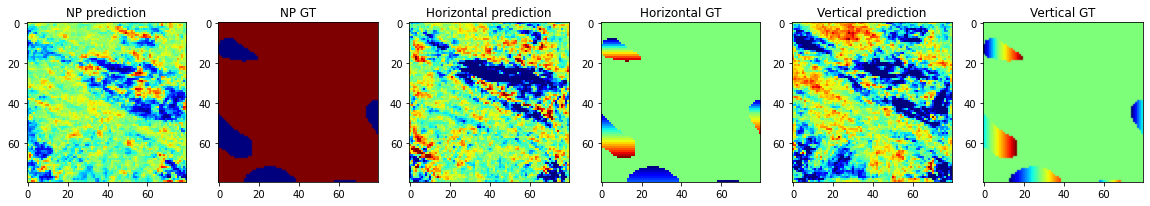

In [ ]:
logi_np = logi_np.detach().cpu()
prob_np = logi_np.softmax(dim=1)[:, 1, :, :].unsqueeze(dim=1)

logi_hv = logi_hv.detach().cpu()
prob_hv = logi_hv


pred_np = colorize(prob_np[:, 0, :, :], cmap='jet')
true_np = colorize(data[1][0, 0, :, :], cmap='jet')
# 🚧🚧 Check the dim=1 index : It's different here: https://github.com/vqdang/hover_net/blob/f5419068da18a338509854b4f8260ee901bff88e/src/model/graph.py#L317
pred_v  = colorize(prob_hv[:, 0, :, :], vmin=-1.0, vmax=1.0, cmap='jet')  
true_v  = colorize(data[2][0, 0, :, :], vmin=-1.0, vmax=1.0, cmap='jet')
pred_h  = colorize(prob_hv[:, 1, :, :], vmin=-1.0, vmax=1.0, cmap='jet')
true_h  = colorize(data[2][0, 1, :, :], vmin=-1.0, vmax=1.0, cmap='jet')

fig, axarr = plt.subplots(1, 6, figsize=(20, 20))
axarr[0].imshow(pred_np[0].numpy(), cmap='jet')
axarr[0].title.set_text("NP prediction")
axarr[1].imshow(true_np.numpy(), cmap='jet')
axarr[1].title.set_text("NP GT")

axarr[2].imshow(pred_h[0].numpy(), cmap='jet')
axarr[2].title.set_text("Horizontal prediction")
axarr[3].imshow(true_h.numpy(), cmap='jet')
axarr[3].title.set_text("Horizontal GT")
axarr[4].imshow(pred_v[0].numpy(), cmap='jet')
axarr[4].title.set_text("Vertical prediction")
axarr[5].imshow(true_v.numpy(), cmap='jet')
axarr[5].title.set_text("Vertical GT")
plt.show()

### 4.4 Loss function

In [ ]:
# NP Loss
def dice_loss(pred, true, smooth=1e-7):
    iflat = pred.view(-1)
    tflat = true.view(-1)
    intersection = (iflat * tflat).sum()
    dice_coeff = (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)

    return 1 - dice_coeff

def loss_np(true, pred):
    loss = F.binary_cross_entropy(pred, true) + self.dice_loss(pred, true)

    return loss


# HV Loss
def get_sobel_filters(size):
    assert size % 2 == 1, "Size must be odd"

    h_range = torch.arange(-size//2 + 1, size//2 + 1, dtype=torch.float32)
    v_range = torch.arange(-size//2 + 1, size//2 + 1, dtype=torch.float32)
    h, v = torch.meshgrid([h_range, v_range])
    h, v = h.transpose(0, 1), v.transpose(0, 1)

    kernel_h = h / (h*h + v*v + 1e-15)
    kernel_v = v / (h*h + v*v + 1e-15)

    return kernel_h, kernel_v

def get_gradient_hv(logits, h_ch=1, v_ch=0):
    mh, mv = get_sobel_filters(size=5)
    mh = mh.reshape(shape=(1, 1, 5, 5))
    mv = mv.reshape(shape=(1, 1, 5, 5))

    hl = logits[:, h_ch, :, :].unsqueeze(dim=1)
    vl = logits[:, v_ch, :, :].unsqueeze(dim=1)

    dh = F.conv2d(hl, mh, stride=1, padding=2)
    dv = F.conv2d(vl, mv, stride=1, padding=2)

    return torch.cat([dh, dv], dim=1)               # 🚧 Check!

def loss_hv(pred, true, focus): 
    true_grad = get_gradient_hv(true, 1, 0)
    pred_grad = get_gradient_hv(pred, 1, 0)

    loss = F.mse_loss(true_grad, pred_grad) * focus # 🚧 Check!
    loss = loss.sum() / (focus.sum() + 1.0e-8)

    return loss


### 4.5 Bringing it all together

In [ ]:

class HoverNet(pl.LightningModule):
    def __init__(self):
        super(HoverNet, self).__init__()
        self.encoder       = _Encoder([3, 4, 6, 3])

        self.decoder_np    = _Decoder()
        self.preact_out_np = _BNRelu(64)

        self.decoder_hv    = _Decoder()
        self.preact_out_hv = _BNRelu(64)
        self.head_np       = _SegmentationHead('np')
        self.head_hv       = _SegmentationHead('hv')

    def forward(self, x):
        enc     = self.encoder(inputs)
        enc[0]  = crop_op(enc[0], (184, 184))
        enc[1]  = crop_op(enc[1], (72, 72))
        
        np_feat = self.decoder_np(enc)
        npx     = self.preact_out_np(np_feat[-1])

        hv_feat = self.decoder_hv(enc)
        hv      = self.preact_out_hv(hv_feat[-1])

        logi_np  = self.head_np(npx)
        logi_hv  = self.head_hv(hv)

        # 🚧 Move this to loss_function?
        # 🚧🚧 get prob_np from logi_np
        # https://github.com/vqdang/hover_net/blob/576ab195e4d8d49aecce51d894d2f292deb4483d/src/model/graph.py#L191

        # 🚧🚧 get pred_hv from logi_hv
        # https://github.com/vqdang/hover_net/blob/576ab195e4d8d49aecce51d894d2f292deb4483d/src/model/graph.py#L197

        return logi_np, logi_hv

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 3e-4)

    def loss_function(self):
        # 🚧🚧 loss_np
        # 🚧🚧 loss_hv
        pass

    def train_dataloader(self):
        ds = OrganDataset("train")
        train_loader = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4, pin_memory=False, shuffle=True)
        return train_loader

    def val_dataloader(self):
        ds = OrganDataset("val")
        val_loader = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4, pin_memory=False, shuffle=False)
        return val_loader

    def test_dataloader(self):
        ds = OrganDataset("test")
        test_loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=False, shuffle=False)
        return test_loader

    def training_step(self, batch, batch_idx):
        # 🚧🚧
        pass

    def validation_step(self, batch, batch_idx):
        # 🚧🚧
        pass

    def validation_epoch_end(self, outputs):
        # 🚧🚧
        pass


## 5 Train

In [ ]:
hovernet = HoverNet()

trainer = pl.Trainer(fast_dev_run=True)

logger.setLevel(logging.DEBUG)
trainer.fit(hovernet)

## 6 Viz Train

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# ☕️
%tensorboard --logdir lightning_logs

## 7 Inference